# Sprint 3: Advanced Relational/Conceptual design

## ToDo:

- Attempt to automate user setup etc.
- [ ] Recommended db setup (ACID)
  - [x] Change SQL code to transactions, i.e. if db update fails (i.e. YF call) NOTHING should be executed
  - [ ] Implement isolation?(Waiting on answer from prof)
  - [x] Add logging to db

Wed:
- [ ] Clean up the file for presentation
- [ ] Advanced conceptual design/relational design explanation

## Summary: Last week's goals

- Data analytics, L3: Use a variety of SQL constructs and indexes to produce readable, efficient, idiomatic queries
- Data modelling, L3: Apply advanced ERD constructs and normalisation methods to produce more natural schemata
- Back end engineering, L1: Create conditions to ensure relational databases exhibit ACID behaviour

## 1. ACID design


### Idea

- Try-except blocks around pymySQL execution statements (1) - (5),

### Implementation

- Broke down program into transactions based on program logic (see below)
- Facilitated by pymysql:
  - Within each try-except block:
  - `connection.start_transaction()`
    - Sql code...
  - `connection.commit()` at end of try block 
  - `conneciton.rollback()` at end of except block

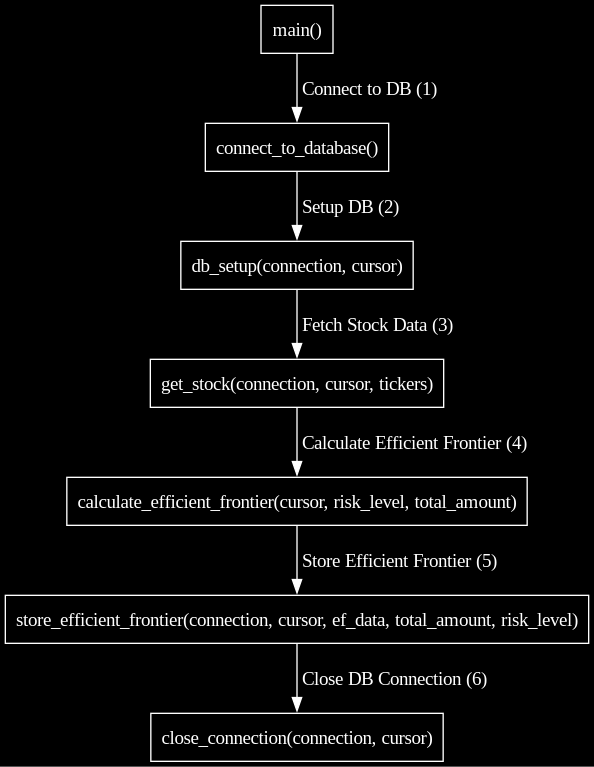

In [11]:
from graphviz import Digraph
from IPython.display import display, Image

# Create a new directed graph
dot = Digraph(comment='Program Logic')

# Set graph attributes for black background and white text/lines
dot.attr(bgcolor='black')
dot.attr('node', style='filled', fillcolor='black', fontcolor='white', color='white', shape='box')
dot.attr('edge', color='white', fontcolor='white')

# Define nodes
dot.node('A', 'main()')
dot.node('B', 'connect_to_database()')
dot.node('C', 'db_setup(connection, cursor)')
dot.node('D', 'get_stock(connection, cursor, tickers)')
dot.node('E', 'calculate_efficient_frontier(cursor, risk_level, total_amount)')
dot.node('F', 'store_efficient_frontier(connection, cursor, ef_data, total_amount, risk_level)')
dot.node('G', 'close_connection(connection, cursor)')

# Define edges
dot.edge('A', 'B', ' Connect to DB (1)')
dot.edge('B', 'C', ' Setup DB (2)')
dot.edge('C', 'D', ' Fetch Stock Data (3)')
dot.edge('D', 'E', ' Calculate Efficient Frontier (4)')
dot.edge('E', 'F', ' Store Efficient Frontier (5)')
dot.edge('F', 'G', ' Close DB Connection (6)')

# Render the graph to a file and display it
dot.render('program_logic', format='png')
display(Image(filename='program_logic.png'))



To make the SQL code conform to ACID properties, we need to ensure that both the creation of tables and the population of tables with data are handled within transactions. This will ensure atomicity, consistency, isolation, and durability.

Here is how you can modify the provided code to use SQL transactions for both creating tables and populating them with data.

### Modifying `db_setup.py` to Use Transactions for Table Creation

First, let's modify the `db_setup.py` file to wrap the table creation statements in a transaction:

```python
import mysql.connector
from mysql.connector import Error

def db_setup(connection, cursor):
    """
    Set up the database schema by executing SQL statements within a transaction.
    
    Parameters:
    connection (MySQLConnection): MySQL connection object.
    cursor (MySQLCursor): MySQL cursor object to execute SQL queries.
    """
    sql_statements = [
        "DROP TABLE IF EXISTS `PortfolioHasAllocation`;",
        "DROP TABLE IF EXISTS `PortfolioHasStock`;",
        "DROP TABLE IF EXISTS `AllocationHasStock`;",
        "DROP TABLE IF EXISTS `StockHasHistory`;",
        "DROP TABLE IF EXISTS `SessionHasPortfolio`;",
        "DROP TABLE IF EXISTS `Session`;",
        "DROP TABLE IF EXISTS `Portfolio`;",
        "DROP TABLE IF EXISTS `Allocation`;",
        "DROP TABLE IF EXISTS `Stocks`;",
        "DROP TABLE IF EXISTS `History`;",
        "CREATE TABLE `Session` (`SessionID` INT PRIMARY KEY);",
        "CREATE TABLE `Portfolio` (`PortfolioID` INT PRIMARY KEY, `TotalAmt` FLOAT, `Risk` VARCHAR(64));",
        "CREATE TABLE `Allocation` (`AllocID` INT PRIMARY KEY, `Ticker` VARCHAR(10), `Amount` FLOAT);",
        "CREATE TABLE `Stocks` (`StockID` INT PRIMARY KEY, `Ticker` VARCHAR(10), `Sector` VARCHAR(64), `Price` FLOAT, `SD` FLOAT, `ERet` FLOAT);",
        "CREATE TABLE `History` (`HistoryID` INT PRIMARY KEY, `Ticker` VARCHAR(10), `Date` VARCHAR(10), `Price` FLOAT);",
        "CREATE TABLE `PortfolioHasStock` (`PortfolioID` INT, `StockID` INT, FOREIGN KEY (`PortfolioID`) REFERENCES `Portfolio`(`PortfolioID`), FOREIGN KEY (`StockID`) REFERENCES `Stocks`(`StockID`), PRIMARY KEY (`PortfolioID`, `StockID`));",
        "CREATE TABLE `AllocationHasStock` (`AllocID` INT, `StockID` INT, FOREIGN KEY (`AllocID`) REFERENCES `Allocation`(`AllocID`), FOREIGN KEY (`StockID`) REFERENCES `Stocks`(`StockID`), PRIMARY KEY (`AllocID`, `StockID`));",
        "CREATE TABLE `StockHasHistory` (`StockID` INT, `HistoryID` INT, FOREIGN KEY (`StockID`) REFERENCES `Stocks`(`StockID`), FOREIGN KEY (`HistoryID`) REFERENCES `History`(`HistoryID`), PRIMARY KEY (`StockID`, `HistoryID`));",
        "CREATE TABLE `SessionHasPortfolio` (`SessionID` INT, `PortfolioID` INT, FOREIGN KEY (`SessionID`) REFERENCES `Session`(`SessionID`), FOREIGN KEY (`PortfolioID`) REFERENCES `Portfolio`(`PortfolioID`), PRIMARY KEY (`SessionID`, `PortfolioID`));",
        "CREATE TABLE `PortfolioHasAllocation` (`PortfolioID` INT, `AllocID` INT, FOREIGN KEY (`PortfolioID`) REFERENCES `Portfolio`(`PortfolioID`), FOREIGN KEY (`AllocID`) REFERENCES `Allocation`(`AllocID`), PRIMARY KEY (`PortfolioID`, `AllocID`));"
    ]

    try:
        connection.start_transaction()
        for sql_statement in sql_statements:
            cursor.execute(sql_statement)
        connection.commit()
        print("SQL script executed successfully.")
    except Error as e:
        connection.rollback()
        print(f"Error executing SQL script: {e}")
```

### Modifying `get_sh.py` to Use Transactions for Data Population

Next, let's modify the `get_sh.py` file to wrap the data population statements in a transaction:

```python
import yfinance as yf
from datetime import datetime, timedelta

def yf_getH(cursor, ticker, stock_id):
    """
    Fetch historical stock data for the given ticker and insert it into the database within a transaction.
    
    Parameters:
    cursor (MySQLCursor): MySQL cursor object to execute SQL queries.
    ticker (str): Stock ticker symbol.
    stock_id (int): Unique stock identifier.
    """
    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        cursor.connection.start_transaction()
        for date, row in hist.iterrows():
            sql = "INSERT INTO History (HistoryID, Ticker, Date, Price) VALUES (%s, %s, %s, %s)"
            data = (stock_id, ticker, date.strftime('%Y-%m-%d'), row['Close'])
            cursor.execute(sql, data)
            print(f"Inserted history data for {ticker} on {date.strftime('%Y-%m-%d')}")
            stock_id += 1
        cursor.connection.commit()
    except Exception as e:
        cursor.connection.rollback()
        print(f"Error fetching or inserting history for {ticker}: {e}")

def yf_getS(cursor, ticker, stock_id):
    """
    Fetch stock information for the given ticker and insert it into the database within a transaction.
    
    Parameters:
    cursor (MySQLCursor): MySQL cursor object to execute SQL queries.
    ticker (str): Stock ticker symbol.
    stock_id (int): Unique stock identifier.
    """
    try:
        stock = yf.Ticker(ticker)
        stock_info = stock.info
        symbol = stock_info.get('symbol', ticker)
        sector = stock_info.get('sector', 'Unknown')
        price = stock_info.get('regularMarketPreviousClose', 0.0)
        sd = stock_info.get('beta', 0.0)
        eret = round((stock_info.get('forwardEps', 0.0) / price) * 100, 3)
        
        cursor.connection.start_transaction()
        insert_statement = "INSERT INTO Stocks (StockID, Ticker, Sector, Price, SD, ERet) VALUES (%s, %s, %s, %s, %s, %s)"
        data = (stock_id, symbol, sector, price, sd, eret)
        cursor.execute(insert_statement, data)
        cursor.connection.commit()
        print(f"Inserted data for {ticker}")
    except Exception as e:
        cursor.connection.rollback()
        print(f"Error fetching or inserting data for {ticker}: {e}")

def get_stock(connection, cursor, tickers):
    """
    Fetch and store stock data for a list of ticker symbols within a transaction.
    
    Parameters:
    connection (MySQLConnection): MySQL connection object.
    cursor (MySQLCursor): MySQL cursor object to execute SQL queries.
    tickers (list): List of stock ticker symbols.
    """
    stock_id = 1
    try:
        connection.start_transaction()
        for ticker in tickers:
            ticker = ticker.strip()
            yf_getS(cursor, ticker, stock_id)
            yf_getH(cursor, ticker, stock_id)
            stock_id += 1000
        connection.commit()
    except Exception as e:
        connection.rollback()
        print(f"Error fetching or inserting stock data: {e}")
```

### Summary

By wrapping the table creation and data population operations in transactions, we ensure that these operations are atomic, consistent, isolated, and durable. This approach helps maintain the integrity of the database even in the event of errors or failures.

* The `db_setup.py` script now ensures that all table creation statements are executed within a single transaction.
* The `get_sh.py` script ensures that data fetching and insertion operations for each stock are executed within transactions, and the overall process of fetching and storing stock data is also wrapped in a transaction.

Citations:
[1] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/22098966/4026eff2-ef75-4a18-b4a3-acd553b8cd14/connect.py
[2] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/22098966/6cc1f0df-6f87-428e-b08b-f87acf9ab8f3/portef.py
[3] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/22098966/8cace1f0-d268-4480-919d-a71c9d95562c/get_sh.py
[4] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/22098966/ba14aa5e-eaf7-4dcd-a8d4-7c5eddc827eb/db_setup.py
[5] https://www.mysqltutorial.org/mysql-stored-procedure/mysql-transactions/
[6] https://www.tutorialspoint.com/mysql/mysql-transactions.htm
[7] https://dev.mysql.com/doc/refman/8.4/en/atomic-ddl.html
[8] https://www.freecodecamp.org/news/how-to-use-mysql-transactions/

When the main program (CLI) encounters an error or requires a rollback, it handles these situations gracefully to maintain the integrity of the database operations. Here is a detailed explanation of how the program behaves in such scenarios, based on the provided code snippets:

## Error Handling and Rollback Mechanisms

### 1. Connection and Setup (`connect.py` and `db_setup.py`)

The `connect.py` script is responsible for establishing a connection to the database. If an error occurs during the connection process, it catches the exception and prints an error message:

```python
try:
    connection = mysql.connector.connect(
        host=host,
        user=username,
        password=password,
        database=database
    )

    if connection.is_connected():
        print(f'Connected to MariaDB database {database} on {host}')
        cursor = connection.cursor()
        cursor.execute("SELECT VERSION()")
        db_version = cursor.fetchone()
        print(f"Database version: {db_version}")
        return connection, cursor

except Error as e:
    print(f"Error connecting to MariaDB database: {e}")
    return None, None
```

### 2. Main Program (`portef.py`)

The main program (`portef.py`) handles the overall workflow, including connecting to the database, setting up the schema, and fetching stock data. It uses a `try-except-finally` block to manage errors and ensure that resources are properly closed:

```python
def main():
    connection, cursor = connect_to_database()
    if connection:
        try:
            tickers_input = input("Enter the stock ticker symbols (separated by commas): ").strip()
            if not tickers_input:
                raise ValueError("Ticker symbols input cannot be empty.")
            tickers = tickers_input.split(',')

            db_setup(connection, cursor)
            get_stock(connection, cursor, tickers)

        except ValueError as ve:
            print(f"Input error: {ve}")

        finally:
            close_connection(connection, cursor)

if __name__ == "__main__":
    main()
```

### 3. Database Setup (`db_setup.py`)

The `db_setup.py` script sets up the database schema. It uses a transaction to ensure atomicity. If an error occurs during the execution of SQL statements, it rolls back the transaction and prints an error message:

```python
def db_setup(connection, cursor):
    sql_statements = [
        # SQL statements for creating tables
    ]

    try:
        connection.start_transaction()
        for sql_statement in sql_statements:
            cursor.execute(sql_statement)
        connection.commit()
        print("SQL script executed successfully.")
    except Error as e:
        connection.rollback()
        print(f"Error executing SQL script: {e}")
```

### 4. Data Population (`get_sh.py`)

The `get_sh.py` script fetches and inserts stock data. It uses transactions to ensure that data insertion is atomic. If an error occurs, it rolls back the transaction and prints an error message:

```python
def yf_getH(cursor, ticker, stock_id):
    try:
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        cursor.connection.start_transaction()
        for date, row in hist.iterrows():
            sql = "INSERT INTO History (HistoryID, Ticker, Date, Price) VALUES (%s, %s, %s, %s)"
            data = (stock_id, ticker, date.strftime('%Y-%m-%d'), row['Close'])
            cursor.execute(sql, data)
            print(f"Inserted history data for {ticker} on {date.strftime('%Y-%m-%d')}")
            stock_id += 1
        cursor.connection.commit()
    except Exception as e:
        cursor.connection.rollback()
        print(f"Error fetching or inserting history for {ticker}: {e}")

def yf_getS(cursor, ticker, stock_id):
    try:
        stock = yf.Ticker(ticker)
        stock_info = stock.info
        symbol = stock_info.get('symbol', ticker)
        sector = stock_info.get('sector', 'Unknown')
        price = stock_info.get('regularMarketPreviousClose', 0.0)
        sd = stock_info.get('beta', 0.0)
        eret = round((stock_info.get('forwardEps', 0.0) / price) * 100, 3)

        cursor.connection.start_transaction()
        insert_statement = "INSERT INTO Stocks (StockID, Ticker, Sector, Price, SD, ERet) VALUES (%s, %s, %s, %s, %s, %s)"
        data = (stock_id, symbol, sector, price, sd, eret)
        cursor.execute(insert_statement, data)
        cursor.connection.commit()
        print(f"Inserted data for {ticker}")
    except Exception as e:
        cursor.connection.rollback()
        print(f"Error fetching or inserting data for {ticker}: {e}")

def get_stock(connection, cursor, tickers):
    stock_id = 1
    try:
        connection.start_transaction()
        for ticker in tickers:
            ticker = ticker.strip()
            yf_getS(cursor, ticker, stock_id)
            yf_getH(cursor, ticker, stock_id)
            stock_id += 1000
        connection.commit()
    except Exception as e:
        connection.rollback()
        print(f"Error fetching or inserting stock data: {e}")
```

## Summary

When the main program encounters an error or needs to perform a rollback:

* **Connection Errors**: The program prints an error message and returns `None` for the connection and cursor.
* **Input Errors**: The program catches `ValueError` exceptions, prints an error message, and proceeds to close the connection.
* **SQL Execution Errors**: The program rolls back the transaction, prints an error message, and ensures that no partial changes are committed to the database.
* **Data Insertion Errors**: Similar to SQL execution errors, the program rolls back the transaction and prints an error message.

This approach ensures that the program maintains the integrity and consistency of the database by handling errors and rollbacks appropriately.

Citations:
[1] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/22098966/4026eff2-ef75-4a18-b4a3-acd553b8cd14/connect.py
[2] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/22098966/6cc1f0df-6f87-428e-b08b-f87acf9ab8f3/portef.py
[3] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/22098966/8cace1f0-d268-4480-919d-a71c9d95562c/get_sh.py
[4] https://ppl-ai-file-upload.s3.amazonaws.com/web/direct-files/22098966/ba14aa5e-eaf7-4dcd-a8d4-7c5eddc827eb/db_setup.py